## Import librairies

In [1]:
import pandas as pd
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
# to install pytorch, follow instructions on https://pytorch.org/get-started/locally/
# if CUDA is installed, this should allow GPU training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# -> pip install torchsummary
from torchsummary import summary
print(torch.cuda.is_available())

True


## Import data

In [2]:
df = pd.read_csv('pl_data.csv', encoding='latin1')

In [3]:
df

,images,category
0,Orange\Orange_177.jpg,Orange
1,Orange\Orange_318.jpg,Orange
2,Orange\Orange_473.jpg,Orange
3,Orange\Orange_202.jpg,Orange
4,Orange\Orange_412.jpg,Orange
...,...,...
1456,Bananes\Banana_262.jpg,Bananes
1457,Bananes\Banana_162.jpg,Bananes
1458,Orange\Orange_59.jpg,Orange
1459,Bananes\Banana_314.jpg,Bananes


In [4]:
df['category']

0        Orange
1        Orange
2        Orange
3        Orange
4        Orange
         ...   
1456    Bananes
1457    Bananes
1458     Orange
1459    Bananes
1460    Bananes
Name: category, Length: 1461, dtype: object

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['category'])
y = le.transform(df['category'])
print(y)
print(y.shape)
print(list(le.inverse_transform([0, 1, 2])))


[1 1 1 ... 1 0 0]
(1461,)
['Bananes', 'Orange', 'Pommes']


In [6]:
X = []
index = 0

for files in df.images: 
    X.append(cv2.cvtColor(cv2.imread(files), cv2.COLOR_BGR2RGB))

X = np.asarray(X)
print(X.shape)


(1461, 100, 100, 3)


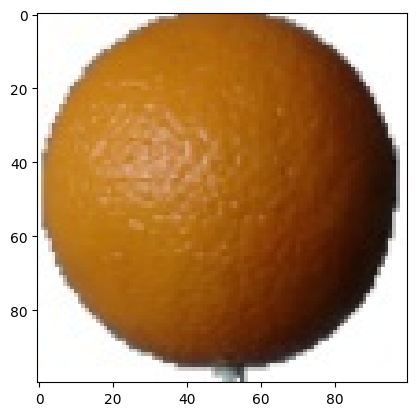

In [7]:
plt.imshow(X[0])

## Split into train and test

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(978, 100, 100, 3)
(978,)
(483, 100, 100, 3)
(483,)


In [35]:
# Define a set of data augmentation transformations
transform = transforms.Compose([
    # transforms.RandomRotation(20, fill=(255, 255, 255)),  # Random rotation with white border
    transforms.RandomAffine(20, translate=(0.2, 0.2), fill=(255, 255, 255)),  # Random shifts with white border
    transforms.RandomHorizontalFlip(),  # Random horizontal flips
    transforms.ColorJitter(brightness=(0.8, 1.2)),  # Random brightness adjustment
    transforms.ToTensor()  # Convert image to tensor
])

# Apply the transformations to the training dataset
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].astype('uint8'))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create the augmented dataset
augmented_dataset = AugmentedDataset(X_train, y_train, transform=transform)

# Create a DataLoader for the augmented dataset
augmented_loader = DataLoader(augmented_dataset, batch_size=10, shuffle=True)

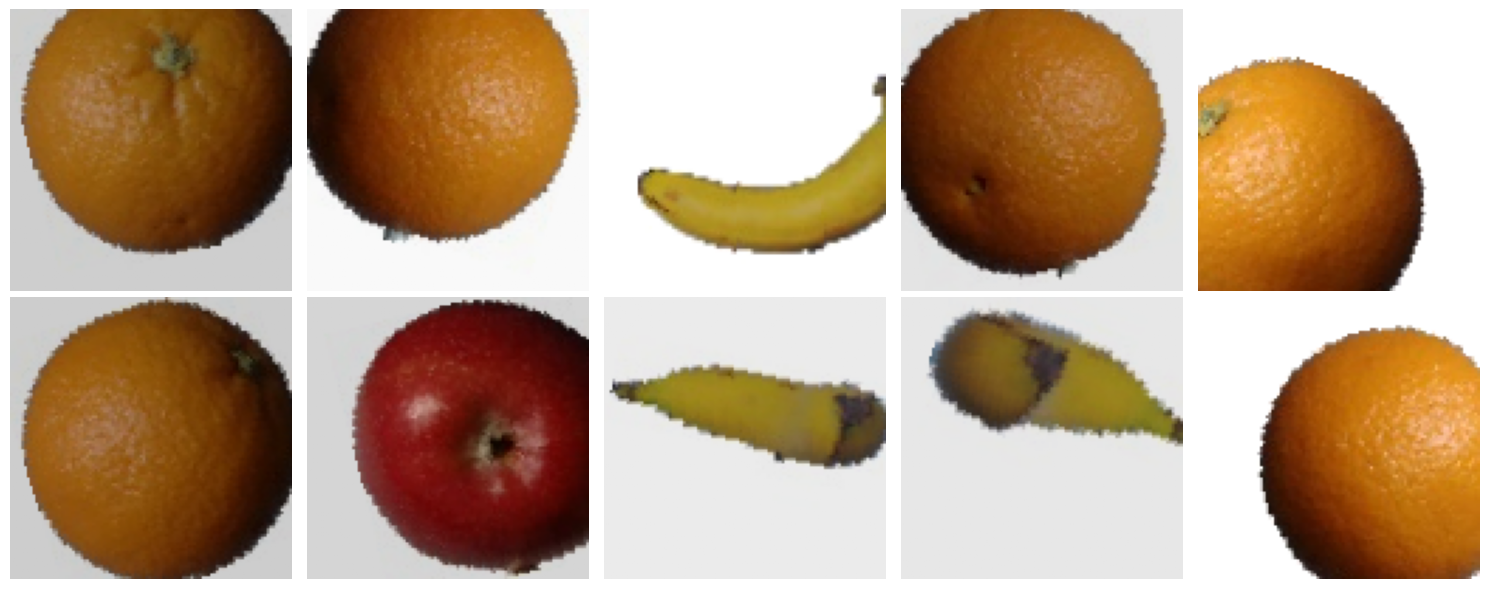

In [10]:
# Generate a batch of augmented images
augmented_images, _ = next(iter(augmented_loader))

# Convert the images to numpy format for visualization
augmented_images = augmented_images.permute(0, 2, 3, 1).numpy()

# Create a grid to display the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Display each image in the grid
for img, ax in zip(augmented_images, axes):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## Build the model

In [11]:


# Define the model
class FruitClassifier(nn.Module):
    def __init__(self):
        super(FruitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)  # Input: (batch_size, 3, 100, 100), Output: (batch_size, 8, 98, 98)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (batch_size, 8, 49, 49)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # Input: (batch_size, 8, 49, 49), Output: (batch_size, 16, 47, 47)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (batch_size, 16, 23, 23)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)  # Input: (batch_size, 16, 23, 23), Output: (batch_size, 32, 21, 21)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (batch_size, 32, 10, 10)
        self.dropout3 = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 10 * 10, 400)  # Adjust input size based on the output of the last pooling layer * 11, 400)  # Adjust input size based on the output of the last pooling layer
        self.dropout4 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(400, 400)
        self.dropout5 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(400, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        # print('Output shape of layer 1', x.shape)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        # print('Output shape of layer 2', x.shape)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)
        # print('Output shape of layer 3', x.shape)
        
        x = self.flatten(x)

        # print('Shape required to pass to Linear Layer', x.shape)

        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x) # Return the raw logits
        return x

# Instantiate the model, use the GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FruitClassifier().to(device)

# test with one batch, to see if the model works. enable the prints in the forward pass for size matching.
# Get one batch of images from the dataloader
images, labels = next(iter(augmented_loader))

# Move the images to the device (GPU/CPU)
images = images.to(device)

# Pass the batch of images through the model
outputs = model.forward(images)

# Print the output shape
print("Output shape:", outputs.shape)

Output shape: torch.Size([10, 3])


In [12]:
# Print the model summary
summary(model, input_size=(3, 100, 100))  # Adjust input size as per your dataset

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 98, 98]             224
         MaxPool2d-2            [-1, 8, 49, 49]               0
           Dropout-3            [-1, 8, 49, 49]               0
            Conv2d-4           [-1, 16, 47, 47]           1,168
         MaxPool2d-5           [-1, 16, 23, 23]               0
           Dropout-6           [-1, 16, 23, 23]               0
            Conv2d-7           [-1, 32, 21, 21]           4,640
         MaxPool2d-8           [-1, 32, 10, 10]               0
           Dropout-9           [-1, 32, 10, 10]               0
          Flatten-10                 [-1, 3200]               0
           Linear-11                  [-1, 400]       1,280,400
          Dropout-12                  [-1, 400]               0
           Linear-13                  [-1, 400]         160,400
          Dropout-14                  [

## Train the model

In [37]:
%%time

batch_size = 5
epochs = 10

#recreate the dataloader with the new batch size
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

# Initialize lists to store loss and accuracy history
loss_history = []
accuracy_history = []

# Define the training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in augmented_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the device (GPU/CPU)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(augmented_loader)
    epoch_accuracy = 100 * correct / total

    # Store the loss and accuracy for this epoch
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 2/10, Loss: 0.0859, Accuracy: 98.26%
Epoch 3/10, Loss: 0.0250, Accuracy: 99.49%
Epoch 4/10, Loss: 0.0001, Accuracy: 100.00%
Epoch 5/10, Loss: 0.0004, Accuracy: 100.00%
Epoch 6/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/10, Loss: 0.0001, Accuracy: 100.00%
Epoch 8/10, Loss: 0.0083, Accuracy: 99.80%
Epoch 9/10, Loss: 0.0806, Accuracy: 98.36%
Epoch 10/10, Loss: 0.0007, Accuracy: 100.00%
CPU times: total: 1.45 s
Wall time: 12.6 s


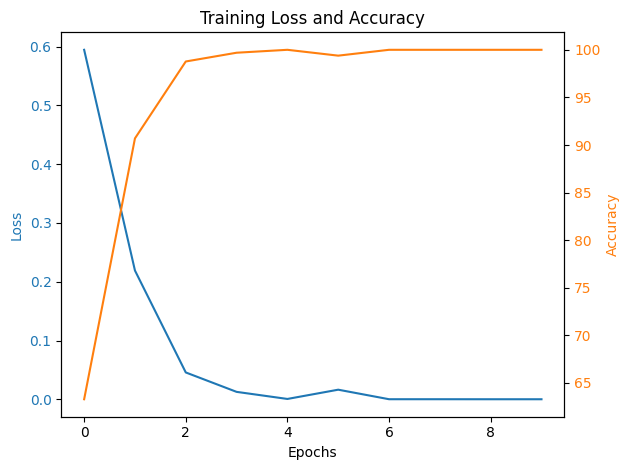

In [14]:
fig, ax1 = plt.subplots()

# Plot loss on the primary y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(loss_history, label='Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.plot(accuracy_history, label='Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title and show the plot
plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()

## Evaluation

In [15]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_tensor = X_test_tensor / 255.0  # normalization
    X_test_tensor = X_test_tensor.to(device)# Convert X_test to tensor and move to device
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)  # Convert y_test to tensor and move to device
    outputs = model(X_test_tensor)  # Forward pass
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    loss = criterion(outputs, y_test_tensor)  # Compute the loss
    accuracy = (y_pred == y_test).sum() / y_test.size  # Compute accuracy using y_pred
    score = [loss.item(), accuracy]

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0000
Test accuracy : 1.0000


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       174
           1     1.0000    1.0000    1.0000       136
           2     1.0000    1.0000    1.0000       173

    accuracy                         1.0000       483
   macro avg     1.0000    1.0000    1.0000       483
weighted avg     1.0000    1.0000    1.0000       483

1.0


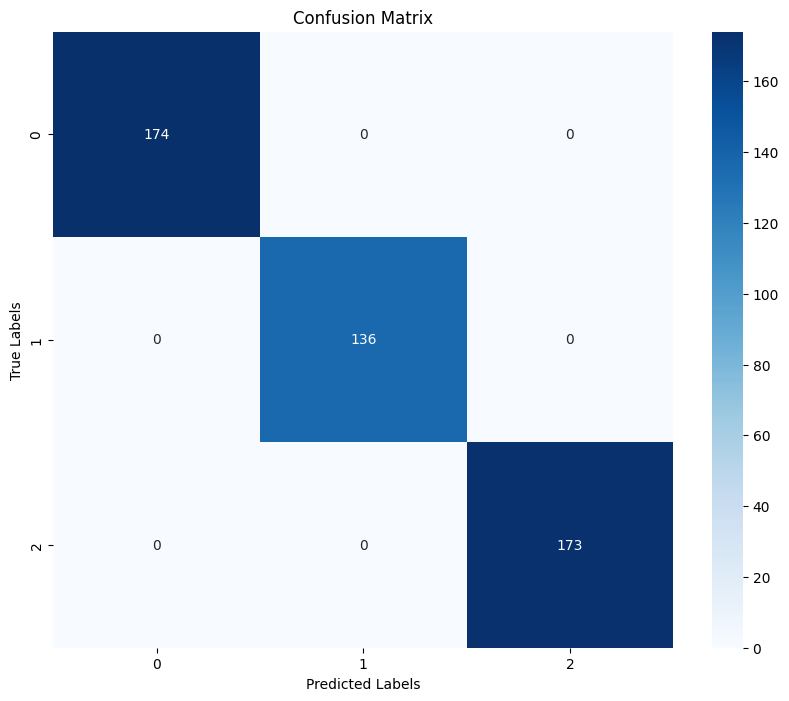

In [16]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# import scikitplot as skplt 

print(classification_report(y_test,y_pred,digits = 4))
print(accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save and load the model and try with new data

In [17]:
# Save the PyTorch model
model_path = "C:\\\\Users\\sacha\\OneDrive - Haute Ecole de Namur-Liege-Luxembourg\\henallux 2024-2025\\Q2\\Systèmes intelligents\\5. Reconnaissance de fruits\\reco.keras"
torch.save(model.state_dict(), model_path)


In [18]:
model2 = FruitClassifier().to(device)
model2.load_state_dict(torch.load(model_path))
model2.eval()  # Set the model to evaluation mode

FruitClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=400, bias=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (dropout5): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=400, out_features=3, bias=True)
)

## Save the model bis

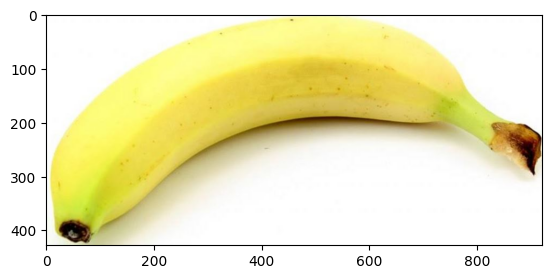

In [19]:
NewData1 = cv2.cvtColor(cv2.imread('NouvelleBanane.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(NewData1)

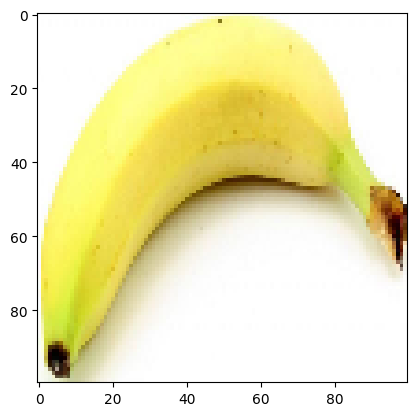

In [20]:
NewData1 = cv2.resize(NewData1,(100,100))
plt.imshow(NewData1)

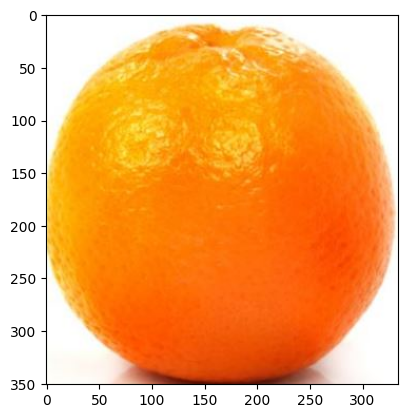

In [21]:
NewData2 = cv2.cvtColor(cv2.imread('NouvelleOrange.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(NewData2)

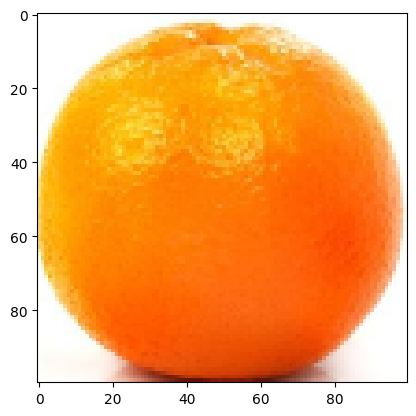

In [22]:
NewData2 = cv2.resize(NewData2,(100,100))
plt.imshow(NewData2)

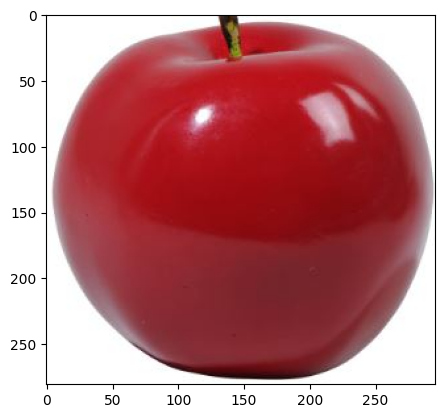

In [23]:
NewData3 = cv2.cvtColor(cv2.imread('NouvellePomme.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(NewData3)

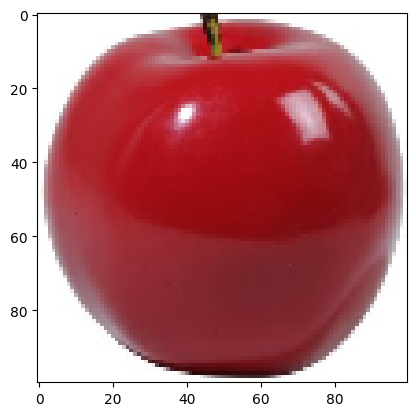

In [24]:
NewData3 = cv2.resize(NewData3,(100,100))
plt.imshow(NewData3)

In [25]:
NewData = np.stack((NewData1,NewData2,NewData3), axis = 0)

In [26]:
NewData.shape

(3, 100, 100, 3)

In [41]:
# Preprocess the NewData
NewData_tensor = torch.tensor(NewData, dtype=torch.float32).permute(0, 3, 1, 2).to(device) / 255.0  # Normalize to [0, 1]

# Set the model to evaluation mode
model2.eval()

# Perform prediction
with torch.no_grad():
    y_sigmoid = model2(NewData_tensor)
    y_pred = torch.argmax(y_sigmoid, axis=-1).cpu().numpy()

print(y_pred)
print(le.inverse_transform(y_pred))

[0 1 2]
['Bananes' 'Orange' 'Pommes']


# Next steps
adapt the code to classify the entire dataset available at https://github.com/Horea94/Fruit-Images-Dataset

Use the proposed train and test separation in the folders. 

first tackle only with the first word of each folder as class : "Apple Braeburn" -> "Apple" 
Then try to differentiate between the different categories of the same fruit.